# Systematics

Now that we understand forward folding and goodness-of-fit, let's talk about how we can handle systematic effects in our datasets.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import h5py
import arviz as av

from instrument_response.toy_simulation import ToySimulation
from instrument_response.detector import Response

from cmdstanpy import CmdStanModel

In [2]:
random_seed = 1

Let's now simulate some data with a simple systematic effect: A shift of the energy in the positive direction, that is proportional to 1.5 multiplied by the original energy. In order to do this, we can use the keyword argument `systematic`, as shown below. 

In [3]:
systematic_shift = 1.5 # TeV

min_energy = 1 # TeV
max_energy = 100 # TeV

true_power_law_index = 2.0
N = int(5e2)
data_file = "output/toy_sim_data_pl_syst.h5"

simulation = ToySimulation(true_power_law_index, min_energy, max_energy, Edep_systematic=systematic_shift)
simulation.run(N, seed=random_seed)
simulation.save(data_file)

Let's compare this data to the earlier data from notebook #2, where we simulated with the same inputs, apart from this new systematic shift. 

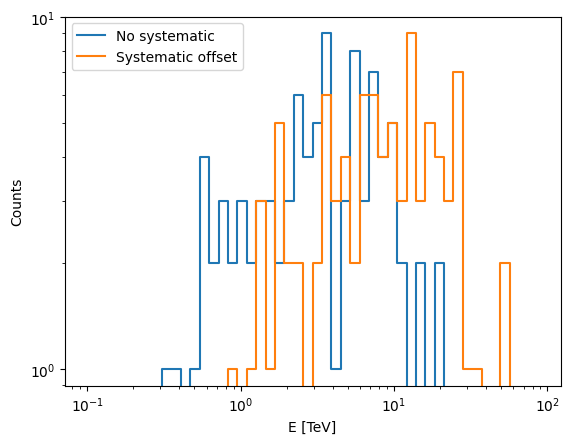

In [4]:
with h5py.File("output/toy_sim_data_pl.h5", 'r') as f:
    detected_energy = f['detected_energy'][()]

with h5py.File("output/toy_sim_data_pl_syst.h5", 'r') as f:
    detected_energy_syst = f['detected_energy'][()]

detected_energy_bins = np.geomspace(0.1, 100)

counts, _ = np.histogram(detected_energy, bins=detected_energy_bins)
counts_syst, _ = np.histogram(detected_energy_syst, bins=detected_energy_bins)

fig, ax = plt.subplots()
ax.step(detected_energy_bins[:-1], counts, where="pre", label="No systematic")
ax.step(detected_energy_bins[:-1], counts_syst, where="pre", label="Systematic offset")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("E [TeV]")
ax.set_ylabel(r"Counts")
ax.legend()

Now, what happens if we ignore this systematic effect and try to fit the data? We can do this by using the response matrix that was generated earlier, where we ran the simulation with no systematic effects included.

In [5]:
# Load response calculated without systematic effects
with h5py.File("output/response_sim.h5", 'r') as f:
    initial_energy = f["initial_energy"][()]
    true_energy = f["true_energy"][()]
    detected_energy = f["detected_energy"][()]

response = Response(initial_energy, true_energy, detected_energy,
                        simulation.effective_area.maximum,
                        nbins_true_energy=50, detected_energy_bins=detected_energy_bins)

# Compile and fit the Stan model
model = CmdStanModel(stan_file="stan/binned_likelihood.stan")

# Run the fit
fit_input = {}
fit_input["Nbins_true"] = response.nbins_true_energy
fit_input["Nbins_detected"] = response.nbins_detected_energy
fit_input["min_energy"] = 1 # TeV
fit_input["max_energy"] = 100 # TeV
fit_input["response_matrix"] = response.matrix
fit_input["true_energy_bins"] = response.true_energy_bins
fit_input["detected_energy_bins"] = response.detected_energy_bins

# Use data that was simulated including systematic effects
fit_input["n"] = counts_syst 

fit = model.sample(data=fit_input, iter_sampling=1000, chains=4)

16:42:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:42:47 - cmdstanpy - INFO - CmdStan done processing.


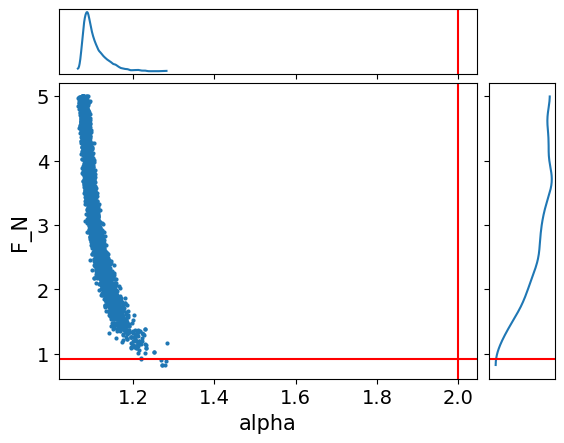

In [6]:
# Load true values from earlier simulation
with h5py.File("output/toy_sim_data_pl_syst.h5", 'r') as f:
    true_alpha = f["power_law_index"][()]
    true_F_N = f["flux_normalisation"][()]

ax = av.plot_pair(fit, var_names=["alpha", "F_N"], marginals=True)
ax[0,0].axvline(true_alpha, color="red")
ax[1,0].axvline(true_alpha, color="red")
ax[1,0].axhline(true_F_N, color="red")
ax[1,1].axhline(true_F_N, color="red")

Hmmm, as expected, it looks like we are unable to recover the true values of the simulation. The fit tries to compensate for the unknown systematic by fitting a hard spectrum.

**Exercise 4.1:** Use your tools from notebook #2 and #3 to evaluate the goodness-of-fit. What do you find? Is it as expected?

In [7]:
# To be completed...

**Exercise 4.2:** Because our simulation has changed, to correctly model our data we need to update the detector response. Adjust the code from notebook #2 to run a new response, including the same systematic effect and verify that we can fit the data well using goodness-of-fit checks. 

In [8]:
# To be completed...

**Exercise 4.3:** We see that we can correctly fit the data by including the systematic effect. However, this effect may not be known a priori. Discuss how we introduce a new fit parameter that describes the systematic, using our simulations. 

We can think about two options:
1. Physics-driven approach
2. Data-driven approach

To help us, we can look at the difference in the two response functions:

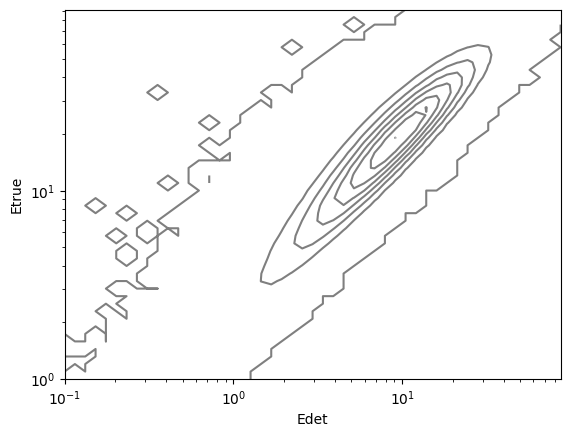

In [10]:
fig, ax = plt.subplots()
ax.contour(detected_energy_bins[:-1], response.true_energy_bins[:-1],
               response.matrix, alpha=0.5, colors="black", levels=7)

# To bw completed...

ax.set_xlabel("Edet")
ax.set_ylabel("Etrue")
#
ax.set_xscale("log")
ax.set_yscale("log")